In [1]:
 ! pip install dill

In [2]:
import model_vae_tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import tensorflow as tf
import dill
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import pickle

/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mz1482/anaconda3/envs/tf_gpu/lib/python3

In [3]:
#Python pickle module is used for serializing and de-serializing a Python object structure.
#Any object in Python can be pickled so that it can be saved on disk.
#What pickle does is that it “serializes” the object first before writing it to file. 
#Pickling is a way to convert a python object (list, dict, etc.) into a character stream. 
#The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

In [4]:
#dill can be used to store python objects to a file,
#but the primary usage is to send python objects across the network as a byte stream. 
#dill is quite flexible, and allows arbitrary user defined classes and functions to be serialized. 
#Thus dill is not intended to be secure against erroneously or maliciously constructed data. 
#It is left to the user to decide whether the data they unpickle is from a trustworthy source.

In [5]:
np.random.seed(0)
tf.set_random_seed(0)

In [6]:
# read the geometry data

filename = 'training_ir_ic_1239'
datapath = '/home/mz1482/project/my_work/data_sets/training_data/'
resultspath = '/home/mz1482/project/my_work/models/'

# latent dimension
latent_dim = 2
train_new_model = True
# train_new_model = False
matver=8

In [7]:
if (matver==7.3):
    import h5py
    with h5py.File(datapath+filename+'.mat', 'r') as matFiles:
        corMfree=np.array(matFiles['corMfree'])
        dataset=np.array(matFiles['param_list'])
        label_aha=np.array(matFiles['label_aha'])
        label_loc=np.array(matFiles['label_loc'])
        label_size=np.array(matFiles['label_size'])
        label_lrv=np.array(matFiles['label_lrv'])
    corMfree=corMfree.T
    
else:
    matFiles = scipy.io.loadmat(datapath+filename+'.mat',squeeze_me=True,
                                struct_as_record=False)
    corMfree=matFiles['corMfree']
    dataset=matFiles['param_list']
    label_aha=matFiles['label_aha']
    label_loc=matFiles['label_loc']
    label_size=matFiles['label_size']
    label_lrv=matFiles['label_lrv']
    dataset=dataset.T

print(corMfree.shape)
print(dataset.shape)
print(label_aha.shape)
print(label_size.shape)


(1239, 3)
(137663, 1239)
(137663,)
(137663,)


In [8]:
# training and testing split
X_train, X_test, aha_train, aha_test, lrv_train, \
lrv_test, loc_train, loc_test, size_train, size_test  = \
    train_test_split(dataset,label_aha,label_lrv,
                     label_loc,label_size, test_size=0.10)
n_samples       = X_train.shape[0]
nte_samples     = X_test.shape[0]
p_dim           = X_train.shape[1]
# training and testing split
# X_train, X_test, size_train, size_test  = \
#     train_test_split(dataset,label_size, test_size=0.10)
# n_samples       = X_train.shape[0]
# nte_samples     = X_test.shape[0]
# p_dim           = X_train.shape[1]


In [9]:
print(p_dim)

1239


In [10]:
# define the vae model
network_architecture = \
    dict(n_hidden_recog_1=512, # 1st layer encoder neurons
         n_hidden_recog_2=512, # 2nd layer encoder neurons
         n_hidden_gener_1=512, # 1st layer decoder neurons
         n_hidden_gener_2=512, # 2nd layer decoder neurons
         n_input=p_dim, # data input dimensionality (e.g., MNIST img shape: 28*28)
         n_z=latent_dim)  # dimensionality of the latent space

vae = model_vae_tf.VariationalAutoencoder(network_architecture, 
                             learning_rate=0.001, 
                             batch_size=64)

In [11]:
if train_new_model:
    with open(resultspath + filename + "/trainingdata.pkl", 'wb') as output:
        pickle.dump(X_train, output, pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mz1482/project/my_work/models/training_ir_ic_1239/trainingdata.pkl'

In [12]:
# constructor of vae starts an interactive session
#tf.reset_default_graph() # remove all tensors in default graph
#vae.sess.close() # close the interactive session of vae object
#del(vae) # just in case

t1 = time.clock()
if train_new_model:    
    model_vae_tf.train(vae, X_train, X_test, batch_size=64, 
                                 training_epochs=100)
    vae.save(resultspath + filename + "/m_" + str(latent_dim) + "d")
    with open(resultspath + filename + "/trainingdata.pkl", 'wb') as output:
        pickle.dump(X_train, output, pickle.HIGHEST_PROTOCOL)
else:
    vae.load(resultspath + filename + "/m_" + str(latent_dim) + "d")

t2 = time.clock()
ttotal = t2-t1
print(ttotal/60)

/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Epoch: 0001 avg cost= 15.781935088
Epoch: 0001 avg test cost= 12.744917288
Epoch: 0006 avg cost= 11.234403741
Epoch: 0006 avg test cost= 11.030960873
Epoch: 0011 avg cost= 10.593925034
Epoch: 0011 avg test cost= 10.553816883
Epoch: 0016 avg cost= 10.296446326
Epoch: 0016 avg test cost= 10.255006576
Epoch: 0021 avg cost= 10.171653898
Epoch: 0021 avg test cost= 10.156957949
Epoch: 0026 avg cost= 10.101681827
Epoch: 0026 avg test cost= 10.054756529
Epoch: 0031 avg cost= 10.042252496
Epoch: 0031 avg test cost= 10.077488966
Epoch: 0036 avg cost= 9.961085733
Epoch: 0036 avg test cost= 9.954111289
Epoch: 0041 avg cost= 9.890898484
Epoch: 0041 avg test cost= 9.875397617
Epoch: 0046 avg cost= 9.869609885
Epoch: 0046 avg test cost= 9.911659594
Epoch: 0051 avg cost= 9.813466174
Epoch: 0051 avg test cost= 9.803717437
Epoch: 0056 avg cost= 9.783100292
Epoch: 0056 avg test cost= 9.711811526
Epoch: 0061 avg cost= 9.751722505
Epoch: 0061 avg test cost= 9.712000687
Epoch: 0066 avg cost= 9.751562203
Epo

/home/mz1482/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


(1, 1239)


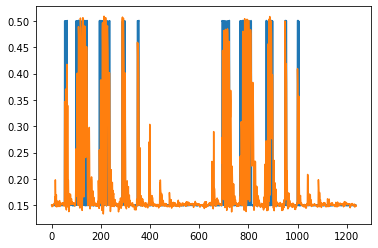

In [13]:
#check it before running/training VAE

inds = np.random.permutation(nte_samples)
x_sample = X_test[inds]
x=x_sample[[1]]
# plt.plot(x)
z_mu = vae.transform(x)
z_mu
x_recon=vae.reconstruct(x)
# x_recon
print(x.shape)
plt.plot(np.array(x[0]))
plt.plot(np.array(x_recon[0]))
plt.show()


(13767, 1239)
(13767, 2)


<Figure size 432x288 with 0 Axes>

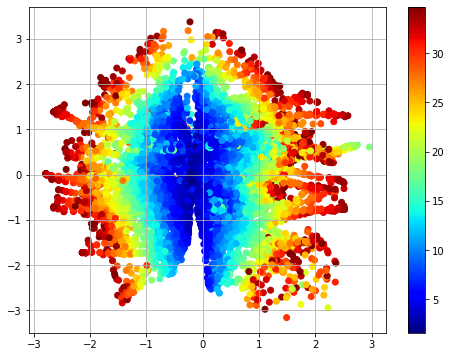

In [14]:
# plot the latent codes
if network_architecture['n_z']==2:
    fig = plt.figure()
    inds = np.random.permutation(nte_samples)
    x_sample = X_test[inds] # train or test specify
    

    z_mu = vae.transform(x_sample)
    print(x_sample.shape)
    print(z_mu.shape)
    plt.figure(figsize=(8, 6)) 
    plt.scatter(z_mu[:, 0], z_mu[:, 1],c=np.squeeze(size_test[inds]), # specify the labels
                cmap=plt.cm.get_cmap('jet'))
    plt.colorbar()
    plt.grid()



In [15]:
# plot the latent codes
if network_architecture['n_z']==2:
    fig = plt.figure()
    inds = np.random.permutation(n_samples)
    x_sample = X_train[inds] # train or test specify
    

    z_mu = vae.transform(x_sample)
    print(x_sample.shape)
    print(z_mu.shape)
    plt.figure(figsize=(8, 6)) 
    plt.scatter(z_mu[:, 0], z_mu[:, 1],c=np.squeeze(size_train[inds]), # specify the labels
                cmap=plt.cm.get_cmap('jet'))
    plt.colorbar()
    plt.grid()


MemoryError: Unable to allocate array with shape (123896, 1239) and data type float32

<Figure size 432x288 with 0 Axes>

[0.3404155  0.3241642  0.4819245  ... 0.14836502 0.14986782 0.14814696]


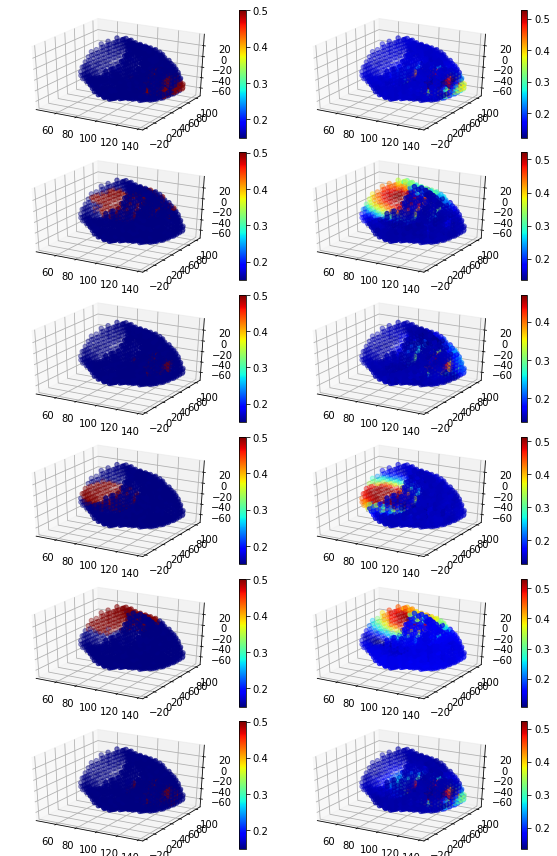

In [16]:
# test the results form the generative model (input vs. reconstruction)
N = 6
inds            = np.random.permutation(nte_samples)
x_sample        = X_test[inds[0:64]] 


x_reconstruct   = vae.reconstruct(x_sample) # encode then decode
print(x_reconstruct[0])
p = 6
fig=plt.figure(figsize=(8, 12))
for i in range(N):
    ax1=fig.add_subplot(N,2,2*i + 1,projection='3d')
    p1=ax1.scatter(corMfree[:,0],corMfree[:,1],corMfree[:,2],c=x_sample[i*p],
                   cmap=plt.cm.get_cmap('jet'))
    fig.colorbar(p1)


    ax2=fig.add_subplot(N, 2, 2*i + 2,projection='3d')
    p2=ax2.scatter(corMfree[:,0],corMfree[:,1],corMfree[:,2],
                   c=x_reconstruct[i*p],cmap=plt.cm.get_cmap('jet'))
    fig.colorbar(p2)
plt.tight_layout()


In [17]:
print(x_sample.shape)
z_mu = vae.transform(x_sample)
z_mu.shape

(64, 1230)


(64, 2)

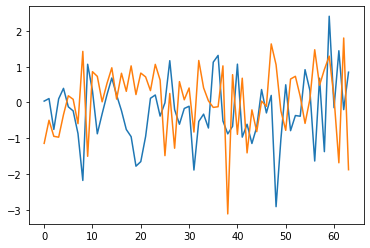

In [18]:
plt.plot(z_mu)
plt.show()

In [ ]:
# plot the latent codes
if network_architecture['n_z']==2:
    fig = plt.figure()
    inds = np.random.permutation(nte_samples)
    x_sample = X_test[inds] # train or test specify
    

    z_mu = vae.transform(x_sample)
    print(x_sample.shape)
    print(z_mu.shape)
    plt.figure(figsize=(8, 6)) 
    plt.scatter(z_mu[:, 0], z_mu[:, 1],c=np.squeeze(aha_test[inds]),s=10, # specify the labels
                cmap=plt.cm.get_cmap('Set1'))
    plt.colorbar()
    plt.grid()

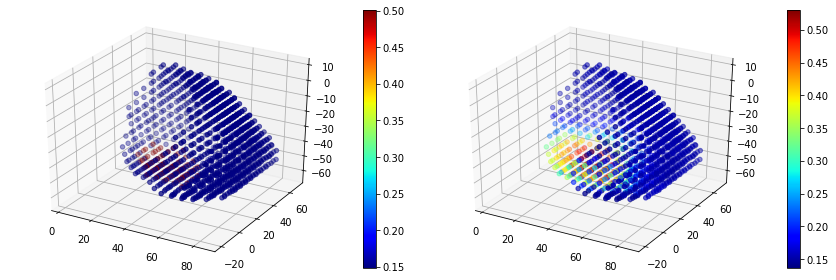

In [67]:
dpath="./data_sets/synthetic_cases/"
dpath = dpath + 'case3/'
#files = ['case3_inf_e4','case3_large','case3_sep_e2','case3_ant_e2','case3_lat_e2','case3_ant_1','case3_antsp_1',
# 'case3_inf_1','case3_inf_lat_2','case3_ap_1','case3_inf_2','case3_inf_lat_1','case3_infsp_1']
# files = ['case3_bas_ant','case3_mid_ant','case3_coordin','case3_ap_ant']
# files = ['case3_inf_e4'] #RPA case
files = ['case3_coordin']
fname = files[0] + '.mat'   
matFiles = scipy.io.loadmat(dpath+fname,squeeze_me=True,struct_as_record=False)
parTrue=matFiles['parTrue']
obs=matFiles['obs']
simu=matFiles['simu']
corMfree=matFiles['corMfree']
N = len(files)
x_sample        = parTrue.reshape(N,-1)
x_reconstruct   = vae.reconstruct(x_sample) # encode then decode
p = N
fig=plt.figure(figsize=(12, 4))
for i in range(N):
    ax1=fig.add_subplot(N,2,2*i + 1,projection='3d')
    p1=ax1.scatter(corMfree[:,0],corMfree[:,1],corMfree[:,2],c=x_sample[i*p],
                   cmap=plt.cm.get_cmap('jet'))
    fig.colorbar(p1)


    ax2=fig.add_subplot(N, 2, 2*i + 2,projection='3d')
    p2=ax2.scatter(corMfree[:,0],corMfree[:,1],corMfree[:,2],
                   c=x_reconstruct[i*p],cmap=plt.cm.get_cmap('jet'))
    fig.colorbar(p2)
plt.tight_layout()

In [22]:
parTrue.shape

(1230,)